# Diffusion Model: Forward Diffusion

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import ipywidgets as widgets

from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import StandardScaler

import requests
from PIL import Image
from io import BytesIO

np.random.seed(100)

En este cuaderno se exploran los principios del proceso de difusión que se utilizan en los llamados modelos de difusión probabilística.

El proceso que en este cuaderno se aborda corresponde al que inglés de conoce como *forward-diffusion*, y el cual consiste en corromper los datos de manera **programada** utilizando un procedimiento de tipo gaussiano.

En este cuaderno se ilustran tres ejemplos de este proceso de corrupción de datos originales:

1. Una distribución *compleja* de datos unidimensionales.
2. Una distribución de puntos en dos dimensiones que siguen un patrón de rollo suizo.
3. Una imagen a color.

Tras destruir los datos originales, la distribución que se obtiene es una de tipo normal (más sencilla).

A continuación se definen dos funciones que serán de utilidad para el ejemplo.

In [ ]:
def multimodal_gaussian(x, modes):
    """
    Genera una distribución multimodal gaussiana.

    Args:
        x: Array de valores en el eje x.
        modes: Tupla que contiene (las medias, desviaciones estandar y pesos) de cada modo.
    Regresa:
        Un array con la distribución multimodal gaussiana.
    """
    total = 0
    for mean, std, weight in modes:
        total += weight * np.exp(-0.5 * ((x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))
    return total

def sample_multimodal(modes, n_samples=1000):
    """
    Muestra datos de una distribución multimodal.

    Args:
        modes: Tupla que contiene (las medias, desviaciones estandar y pesos) de cada modo.
        n_samples: Número de muestras a generar.
    Regresa:
        Un array con las muestras.
    """

    weights = np.array([w for _, _, w in modes])
    weights /= weights.sum()

    samples = []
    for _ in range(n_samples):

        mode_idx = np.random.choice(len(modes), p=weights)
        mean, std, _ = modes[mode_idx]
        samples.append(np.random.normal(mean, std))

    return np.array(samples)

# 1. Degradación por difusión de una colección de muestras en un espacio unidimensional.

En la siguiente celda se define un intervalo de `min_value` a `max_value` a partir del cual se genera una distribución multimodal con el número de modos especificado en `num_modes`. Con `num_samples` se especifica el número de puntos a muestrear de la distribución multimodal.

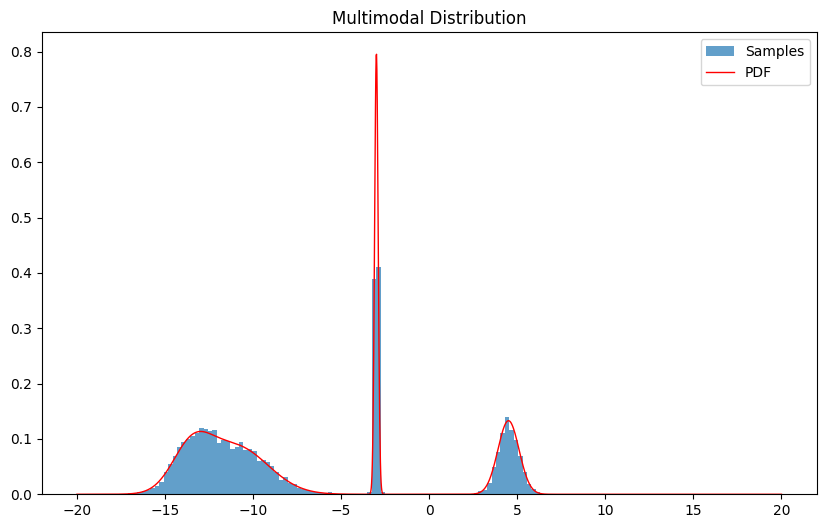

In [ ]:
min_value = -20
max_value = 20
num_modes = 4
num_samples = 10000

means = np.random.choice(np.arange(min_value+5,max_value-5,0.5), num_modes)
stds = np.random.choice(np.arange(0.1,2.25,0.25), num_modes)

weights = np.random.choice(np.arange(1,10), num_modes)
weights = weights/weights.sum()

modes = [(mean, std, weight) for mean, std, weight in zip(means, stds, weights)]

samples = sample_multimodal(modes, num_samples)

x = np.linspace(min_value, max_value, 2000)
y = multimodal_gaussian(x, modes)

plt.figure(figsize=(10, 6))
plt.hist(samples, bins=100, density=True, alpha=0.7, label='Samples')
plt.plot(x, y, 'r-', linewidth=1, label='PDF')
plt.legend()
plt.title('Multimodal Distribution')
plt.show()

Ahora se definirá la agenda con la que los datos muestreados a partir de la distribución multimodal se corromperán. Para este propósito, la variable `steps` *t* define el número de pasos que contiene la agenda a implementar.Con los `steps` definidos, se genera un array mediante la función `np.linspace` que se llama `betas`. `betas` contiene una serie de hiperparámetros $\beta_t$ a implementar en cada paso *t*.

La manera en que se destruirán los datos es mediante una agenda programada mediante la siguiente fórmula:

$$x_t = \sqrt{1-\beta_t}x_{t-1} + \sqrt{\beta_t}\epsilon$$ (eq. 1)

donde $\epsilon$ ~ $\mathcal{N}(0,I)$.

En esta fórmula $x_t$ representa a la muestra corrompida en el paso *t*. Como se puede observar, el estado de $x_t$ sólo depende del estado inmediato anterior $x_{t-1}$. Por esta razón, se dice que el proceso de difusión corresponde a una cadena de Markov.

También es importante señalar que, debido a la agenda implementada, los coeficientes $\sqrt{1-\beta_t}$ son valores cercanos a la unidad, mientras que la contribución del ruido $\epsilon$ es cercana a cero, $\sqrt{\beta_t}$.

In [ ]:
steps = 1000
betas = np.linspace(1e-4, 2e-2, steps)

samples_t = list()
for t in range(steps):
    if t == 0:
        n_samples = np.sqrt(1-betas[t])*samples + np.sqrt(betas[t])*np.random.normal(size=num_samples)
        samples_t += [n_samples]
    else:
        n_samples = np.sqrt(1-betas[t])*samples_t[t-1] + np.sqrt(betas[t])*np.random.normal(size=num_samples)
        samples_t += [n_samples]

samples_t = np.stack(samples_t).T
samples_t = np.concatenate((samples[:,None], samples_t), axis=-1)


Ahora visuliza cómo las muestras obtenidas de la distribución multimodal se modifican tras la aplicación de la fórmula antes mencionada en cada paso *t*.

Se podrá observar que, con adiciones pequeñas de ruido en cada paso *t*, la distribución original (compleja) pasa a tener un perfil normal (simple). Esta transformación es más viable de obtener cuando el número de pasos en la agenda es grande.

In [ ]:
@interact(t=IntSlider(value=0, min=0, max=steps, step=1))
def update_hist(t = 1):
    plt.figure()
    plt.hist(samples_t[:,t], bins=100, density=True,
             label='time step:{:d}'.format(t))
    plt.legend(loc='best')
    plt.show()

interactive(children=(IntSlider(value=0, description='t', max=1000), Output()), _dom_classes=('widget-interact…

Al trabajar de manera recursiva la ecuación 1, considerando las propiedades que tienen el producto de gaussianas, se encuentra una expresión que establece cómo hay que distorsionar los datos originales $x_0$ para conseguir los datos degradados en la instancia $x_t$. La fórmula es la siguiente:

$$x_t = \sqrt{\bar{\alpha_t}}x_{0} + \sqrt{1-\bar{\alpha_t}}\epsilon$$

donde $$\bar{\alpha_t} = \prod_{i=1}^t\alpha_i$$ y $$\alpha_t=1-\beta_t$$.

En la siguiente celda se exploran los cambios que tiene las variables $\beta_t$, $\alpha_t$, $\bar{\alpha_t}$ en cada paso *t*. Es importante señalar que las muestras degradadas que corresponden a la instancia $x_t$ siguen un perfil gaussiano donde $\mu_t = \sqrt{\bar{\alpha_t}} x_0$ y $\sigma_t = \sqrt{1-\bar{\alpha_t}}$.

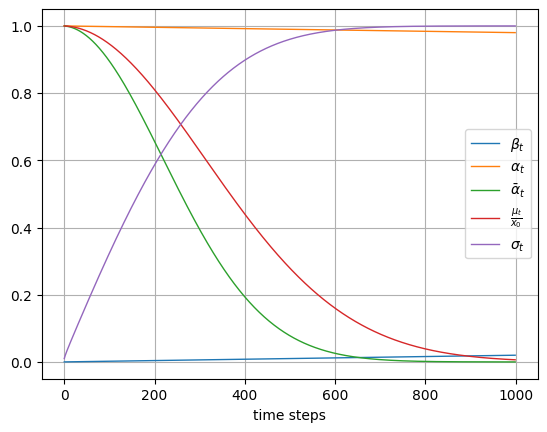

In [ ]:
steps = 1000
betas = np.linspace(1e-4, 2e-2, steps)
alphas = 1 - betas
alpha_prods = np.cumprod(alphas)
mu_t_xo = np.sqrt(alpha_prods)
sigma_t = np.sqrt(1-alpha_prods)

plt.figure()
plt.plot(np.arange(steps), betas, linewidth=1, label=r'$\beta_t$')
plt.plot(np.arange(steps), alphas, linewidth=1, label=r'$\alpha_t$')
plt.plot(np.arange(steps), alpha_prods, linewidth=1,
         label=r'$\bar{\alpha}_t$')
plt.plot(np.arange(steps), mu_t_xo, linewidth=1,
         label=r'$\frac{\mu_t}{x_0}$')
plt.plot(np.arange(steps), sigma_t, linewidth=1,
         label=r'$\sigma_t$')
plt.legend(loc='best')
plt.xlabel('time steps')
#plt.yscale('log')
plt.grid(True)
plt.show()

Como se puede observar, el final de la agenda programada se tiene que los datos siguen un comportamiento normal, como media cero y desviación estándar uno.

En la siguiente celda se implementa la agenda a partir de la fórmula 2. En esta implementación prescinde del bucle for-loop implementado en la fórmula 1.

In [ ]:
epsilon = np.random.normal(size=(num_samples, steps))
samples_t = samples[:,None] @ mu_t_xo[None,:] + sigma_t[None,:] * epsilon
samples_t = np.concatenate((samples[:,None], samples_t), axis=-1)
sigma_t = np.concatenate((np.zeros(1,), sigma_t))
mu_t_xo = np.concatenate((np.ones(1,), mu_t_xo))

In [ ]:
@interact(t=IntSlider(value=0, min=0, max=steps, step=1))
def update_hist(t = 1):
    plt.figure()
    plt.hist(samples_t[:,t], bins=100, density=True,
             label='time step:{:d}\nmean/x_0:{:.4f}\nstd:{:.4f}'.format(t, mu_t_xo[t], sigma_t[t]))
    plt.legend(loc='best')
    plt.show()

interactive(children=(IntSlider(value=0, description='t', max=1000), Output()), _dom_classes=('widget-interact…

Como se puede observar, el resultado es el mismo ya sea con la fórmula 1 o la 2. En la práctica, el proceso de degradación por difusión se implementa siguiendo la fórmula 2.

# 2. Degradación por difusión de una colección en dos dimensiones con patrón de rollo suizo.

In [ ]:
steps = 1000
betas = np.linspace(1e-4, 2e-2, steps)
alphas = 1 - betas
alpha_prods = np.cumprod(alphas)
mu_t_xo = np.sqrt(alpha_prods)
sigma_t = np.sqrt(1-alpha_prods)

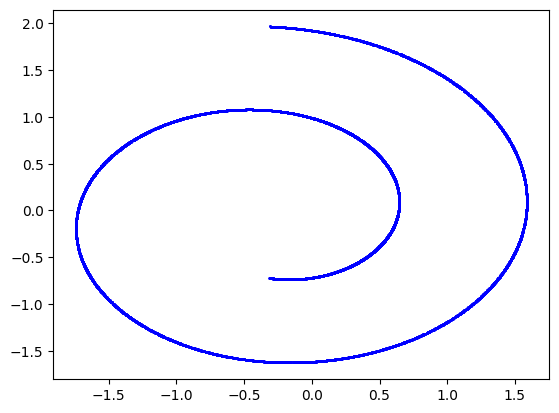

In [ ]:
nsamples = 10000
swiss_roll = make_swiss_roll(n_samples=nsamples)[0]
swiss_roll = swiss_roll[:,[0,2]]
swiss_roll = StandardScaler().fit_transform(swiss_roll)

plt.figure()
plt.scatter(swiss_roll[:,0], swiss_roll[:,1], s=1, color='blue')
plt.show()

In [ ]:
swiss_roll_corrupted = swiss_roll[:,:,None] * mu_t_xo[None, None, :] + sigma_t[None, None, :] * np.random.normal(size=(nsamples, 2, steps))
swiss_roll_corrupted = np.concatenate((swiss_roll[...,None], swiss_roll_corrupted), axis=-1)
sigma_t = np.concatenate((np.zeros(1,), sigma_t))
mu_t_xo = np.concatenate((np.ones(1,), mu_t_xo))

@interact(t=IntSlider(value=0, min=0, max=steps, step=1))
def update_swiss_roll(t = 1):
    plt.figure()
    plt.scatter(swiss_roll_corrupted[:,0,t], swiss_roll_corrupted[:,1,t], s=1, color='blue',
             label='time step:{:d}\nmean:{:.4f}\nstd:{:.4f}'.format(t, mu_t_xo[t], sigma_t[t]))
    plt.legend(loc='best')
    plt.show()

interactive(children=(IntSlider(value=0, description='t', max=1000), Output()), _dom_classes=('widget-interact…

# 3. Degradación por difusión de una imagen RGB.

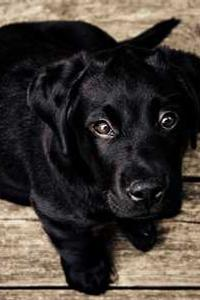

In [ ]:
url = "https://picsum.photos/id/237/200/300.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img_array = np.array(img)
img_array = img_array/127.5 - 1
img

In [ ]:
steps = 1000
betas = np.linspace(1e-4, 2e-2, steps)
alphas = 1 - betas
alpha_prods = np.cumprod(alphas)
mu_t_xo = np.sqrt(alpha_prods)
sigma_t = np.sqrt(1-alpha_prods)

img_corrupted = img_array[None,...] * mu_t_xo[:,None,None,None] + sigma_t[:,None,None,None] * np.random.normal(size=(steps, 300, 200, 3))
img_corrupted = np.concatenate((img_array[None,...], img_corrupted), axis=0)
mu_t_xo = np.concatenate((np.ones(1,), mu_t_xo))
sigma_t = np.concatenate((np.zeros(1,), sigma_t))


In [ ]:
@interact(t=IntSlider(value=0, min=0, max=steps, step=1))
def watch_corrupted_image(t = 1):
    plt.figure()
    plt.imshow((127.5*(img_corrupted[t]+1)).astype(int))
    plt.show()

interactive(children=(IntSlider(value=0, description='t', max=1000), Output()), _dom_classes=('widget-interact…